## Fine-Tuning DistilBERT on Stratified Sample of Yelp Review Data for Sentiment Analysis

### 0. Set-up and Imports
Load required libraries and set environment/device configurations

In [ ]:
import os
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_fscore_support, precision_score, recall_score
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [3]:
nltk.download('stopwords')
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
batch_size = 16
sample_fraction = 0.1  # Stratified sampling ratio
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jessting/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1. Dataset Set-up

- **Text Processing**:
    - `clean_token`, `clean_text`: Utility functions to clean review text while preserving special tokens
    - `augment_text`: Add structured metadata (e.g., time period, engagement tags, business maturity, stability, and location) to review text for contextual fine-tuning

In [4]:
punct_table = str.maketrans('', '', string.punctuation)

def clean_token(token):
    return token.translate(punct_table).replace('##', '')

def clean_text(text):
    special_tokens = re.findall(r'\[.*?\]', text)
    cleaned = re.sub(r'[^a-zA-Z\s]', '', text)
    for token in special_tokens:
        cleaned = cleaned.replace(token.strip('[]'), '').strip() + f' {token}'
    return cleaned.strip()

def augment_text(row):
    tokens = [
        '[PRE_2020]' if row['pre_2020'] else '[POST_2020]',
        '[USEFUL]' if row['engagement_useful'] else '[NOT_USEFUL]',
        '[FUNNY]' if row['engagement_funny'] else '[NOT_FUNNY]',
        '[COOL]' if row['engagement_cool'] else '[NOT_COOL]',
        '[ESTABLISHED]' if row['established'] else '[NEW_BUSINESS]',
        '[HIGH_STABILITY]' if row['rating_stability'] < 0.5 else '[LOW_STABILITY]',
        f'[{row["state"]}]',
        clean_text(row['text'])
    ]
    return ' '.join(tokens)

- **Stratified Sampling**:
Perform stratified sampling using a composite sampling_strata variable constructed from review-, user-, and business-level features, filtering out underrepresented states and rare strata combinations to ensure robust sampling

In [5]:
full_df = pd.read_csv('reviews_working.csv', index_col=0)
full_df['sampling_strata'] = (
    full_df['positive_review'].astype(str) + '_' +
    full_df['stars_review'].round().astype(int).astype(str) + '_' +  # Round star ratings to integers
    full_df['pre_2020'].astype(str) + '_' +
    full_df['engagement_useful'].astype(str) + '_' +
    full_df['engagement_funny'].astype(str) + '_' +
    full_df['engagement_cool'].astype(str) + '_' +
    full_df['established'].astype(str) + '_' +
    (full_df['rating_stability'] < 0.5).astype(str)  # HIGH_STABILITY condition
)

state_counts = full_df['state'].value_counts()
sufficient_states = state_counts[state_counts > 50].index
full_df['state_strata'] = full_df['state'].where(full_df['state'].isin(sufficient_states), 'OTHER_STATES')
full_df['sampling_strata'] = full_df['sampling_strata'] + '_' + full_df['state_strata']
print(f"Original dataset size: {len(full_df)}")
print(f"Number of unique strata: {full_df['sampling_strata'].nunique()}")
print("Sample strata counts:")
print(full_df['sampling_strata'].value_counts().head(3))
print(full_df['sampling_strata'].value_counts().tail(3))

strata_counts = full_df['sampling_strata'].value_counts()
full_df['grouped_strata'] = full_df['sampling_strata'].apply(
    lambda x: x if strata_counts[x] > 5 else 'RARE_COMBINATION'
)
sss = StratifiedShuffleSplit(n_splits=1, test_size=sample_fraction, random_state=123)
for _, sample_idx in sss.split(full_df, full_df['grouped_strata']):
    df = full_df.iloc[sample_idx].copy()
print(f"\nSampled dataset size: {len(df)}")
print("Sampled strata distribution:")
print(df['sampling_strata'].value_counts().head(3))
print(df['sampling_strata'].value_counts().tail(3))

Original dataset size: 1625644
Number of unique strata: 4198
Sample strata counts:
sampling_strata
1_5_True_False_False_False_True_True_PA     26498
1_4_True_False_False_False_True_False_PA    23898
1_5_True_False_False_False_True_False_PA    23750
Name: count, dtype: int64
sampling_strata
0_2_True_False_True_True_False_True_ID       1
0_3_False_False_False_True_False_False_IL    1
0_3_True_False_False_True_False_True_DE      1
Name: count, dtype: int64

Sampled dataset size: 162565
Sampled strata distribution:
sampling_strata
1_5_True_False_False_False_True_True_PA     2650
1_4_True_False_False_False_True_False_PA    2390
1_5_True_False_False_False_True_False_PA    2375
Name: count, dtype: int64
sampling_strata
0_3_False_False_False_True_True_True_TN    1
0_1_True_False_True_True_False_False_TN    1
0_2_True_False_True_True_False_False_NV    1
Name: count, dtype: int64


- **Tokenization and Length Filtering**: 
    - Loads Hugging Face tokenizer and defines custom special tokens
    - Applies tokenizer to the augmented review text and filters out reviews exceeding the model’s max token length

In [ ]:
model_name = 'distilbert-base-uncased-finetuned-sst-2-english'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Add special tokens
state_tokens = [f'[{state}]' for state in df['state'].unique()]
special_tokens_dict = {
    'additional_special_tokens': [
        '[PRE_2020]', '[POST_2020]',
        '[USEFUL]', '[NOT_USEFUL]',
        '[FUNNY]', '[NOT_FUNNY]',
        '[COOL]', '[NOT_COOL]',
        '[ESTABLISHED]', '[NEW_BUSINESS]',
        '[HIGH_STABILITY]', '[LOW_STABILITY]'
    ] + state_tokens
}
tokenizer.add_special_tokens(special_tokens_dict)

# Remove obs with token length > max allowable length
df['augmented_text'] = df.apply(augment_text, axis=1)
token_lengths = df['augmented_text'].apply(lambda x: len(tokenizer.tokenize(x)))
df = df[token_lengths <= tokenizer.model_max_length].copy().reset_index(drop=True)

Token indices sequence length is longer than the specified maximum sequence length for this model (716 > 512). Running this sequence through the model will result in indexing errors


- **Class Weight Computation**: Calculate class weights based on label frequency to address imbalance during model training

In [7]:
class_dist = df['positive_review'].value_counts(normalize=True)
class_weights = torch.tensor(
    compute_class_weight('balanced', classes=np.unique(df['positive_review']), y=df['positive_review']),
    dtype=torch.float
).to(device)

### 2. Dataset Class & Trainer Definition

- **Custom Dataset**: Define a PyTorch Dataset class that tokenizes input review text and returns inputs in the format expected by Hugging Face models
- **Weighted Trainer**: Subclass Hugging Face’s Trainer to incorporate a class-weighted loss function, addressing imbalance in the binary sentiment labels
- **Train/Validation/Test Split**: Perform a 60/20/20 stratified split on the sampled dataset to preserve label distribution across subsets

In [ ]:
# Dataset class 
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts.values if isinstance(texts, pd.Series) else texts
        self.labels = labels.values if isinstance(labels, pd.Series) else labels
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        text = self.texts[idx] if isinstance(self.texts[idx], str) else str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=512,
            padding='max_length',
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long),
            'text': text
        }

    def __len__(self):
        return len(self.texts)

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get('labels')
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['positive_review'])
train_df, val_df = train_test_split(train_df, test_size=0.25, stratify=train_df['positive_review'])  # 60/20/20 split
train_dataset = ReviewDataset(train_df['augmented_text'], train_df['positive_review'], tokenizer)
val_dataset = ReviewDataset(val_df['augmented_text'], val_df['positive_review'], tokenizer)
test_dataset = ReviewDataset(test_df['augmented_text'], test_df['positive_review'], tokenizer)

- **Training Configuration**: Set training arguments for fine-tuning, including early stopping criteria, evaluation strategy, and optimizer settings
- **Model Initialization & Training**: Load and fine-tune DistilBERT with custom tokens, save the model and tokenizer for downstream inference
- **Baseline Setup**: Load the original pre-trained DistilBERT model as a benchmark for post-hoc evaluation

In [ ]:
# Training Config
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0)
    acc = accuracy_score(labels, preds)
    metrics = {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}
    if abs(class_dist[0] - class_dist[1]) > 0.2:
        min_class = np.argmin(class_weights.cpu().numpy())
        p, r, f, _ = precision_recall_fscore_support(labels, preds, labels=[min_class], average=None)
        metrics.update({f'precision_class{min_class}': p[0], f'recall_class{min_class}': r[0], f'f1_class{min_class}': f[0]})
    return metrics

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    eval_strategy='steps',
    eval_steps=500,
    save_strategy='steps',
    save_steps=500,
    logging_dir='./logs',
    logging_steps=100,
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    fp16=False,
    gradient_accumulation_steps=2,
    gradient_checkpointing=True,
    optim='adamw_torch'
)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.resize_token_embeddings(len(tokenizer))
model.to(device)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)
trainer.train()
model.save_pretrained('./yelp_finetuned_distilbert')
tokenizer.save_pretrained('./yelp_finetuned_distilbert')

base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
base_tokenizer = AutoTokenizer.from_pretrained(model_name)

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Precision Class1,Recall Class1,F1 Class1
500,0.274600,0.302887,0.913274,0.937448,0.923202,0.952140,0.923202,0.952140,0.937448
1000,0.255400,0.248224,0.918149,0.939577,0.946870,0.932396,0.946870,0.932396,0.939577
1500,0.264100,0.221588,0.919205,0.940079,0.951872,0.928575,0.951872,0.928575,0.940079
2000,0.253800,0.212936,0.923583,0.943577,0.951100,0.936172,0.951100,0.936172,0.943577
2500,0.250400,0.239722,0.925695,0.946490,0.930695,0.962832,0.930695,0.962832,0.946490
3000,0.209300,0.228764,0.919919,0.940349,0.956432,0.924799,0.956432,0.924799,0.940349
3500,0.236900,0.226445,0.917404,0.937891,0.963400,0.913698,0.963400,0.913698,0.937891
4000,0.201800,0.216956,0.927993,0.947063,0.950426,0.943724,0.950426,0.943724,0.947063
4500,0.218700,0.221211,0.929204,0.948845,0.936075,0.961967,0.936075,0.961967,0.948845
5000,0.206700,0.254270,0.930042,0.949035,0.943805,0.954324,0.943805,0.954324,0.949035


### 3. Model-Level Results & Evaluation

- **Threshold Optimization**: Identify optimal classification threshold by selecting value that maximizes F1 score on validation set
- **Model Evaluation**: Apply both baseline and fine-tuned models to held-out test set to compute accuracy, precision, recall, and F1 score

In [ ]:
# Evaluate model
def find_optimal_threshold(model, dataset, tokenizer, batch_size):
    probs = []
    labels = []
    for i in range(0, len(dataset), batch_size):
        batch_items = [dataset[i+j] for j in range(min(batch_size, len(dataset)-i))]
        batch_texts = [item['text'] for item in batch_items]
        batch_labels = [item['labels'] for item in batch_items]
        
        inputs = tokenizer(
            batch_texts,
            return_tensors='pt',
            padding=True,
            truncation=True,
            max_length=512
        ).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
            probs.extend(torch.softmax(outputs.logits, dim=1)[:,1].cpu().numpy())
            labels.extend(batch_labels)
    
    thresholds = np.linspace(0.1, 0.9, 50)
    f1_scores = [f1_score(labels, np.array(probs) > t) for t in thresholds]
    return thresholds[np.argmax(f1_scores)]

def evaluate_model(model, tokenizer, dataset, threshold=0.5, batch_size=8):
    model.eval()
    probs = []
    labels = []
    
    for i in tqdm(range(0, len(dataset), batch_size), desc='Evaluating'):
        batch_items = [dataset[i+j] for j in range(min(batch_size, len(dataset)-i))]
        batch_texts = [item['text'] for item in batch_items]
        batch_labels = [item['labels'] for item in batch_items]
        
        inputs = tokenizer(
            batch_texts,
            return_tensors='pt',
            padding=True,
            truncation=True,
            max_length=512
        ).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
            probs.extend(torch.softmax(outputs.logits, dim=1)[:,1].cpu().numpy())
            labels.extend(batch_labels)
    
    preds = (np.array(probs) > threshold).astype(int)
    return {
        'probs': probs,
        'labels': labels,
        'preds': preds,
        'accuracy': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds),
        'recall': recall_score(labels, preds),
        'f1': f1_score(labels, preds)
    }

optimal_threshold = find_optimal_threshold(model, val_dataset, tokenizer, batch_size)
print(f'Optimal threshold: {optimal_threshold:.4f}')

base_results = evaluate_model(base_model, base_tokenizer, test_dataset, 0.5, batch_size)
ft_results = evaluate_model(model, tokenizer, test_dataset, optimal_threshold, batch_size)

test_df['base_prob'] = base_results['probs']
test_df['ft_prob'] = ft_results['probs']
test_df['base_label'] = base_results['preds']
test_df['pred_label'] = ft_results['preds']
test_df['diff'] = np.abs(test_df['ft_prob'] - test_df['base_prob']) 

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Optimal threshold: 0.3612


Evaluating: 100%|██████████| 2013/2013 [09:02<00:00,  3.71it/s]


- **Prediction Comparison**: Store predicted probabilities and sentiment labels from each model for side-by-side comparison
- **Visualization of Outputs**: Plot predicted sentiment scores and confusion matrices to highlight differences in model behavior and classification accuracy
- **Metrics Summary**: Compile evaluation results into a comparison table to summarize model performance across key metrics

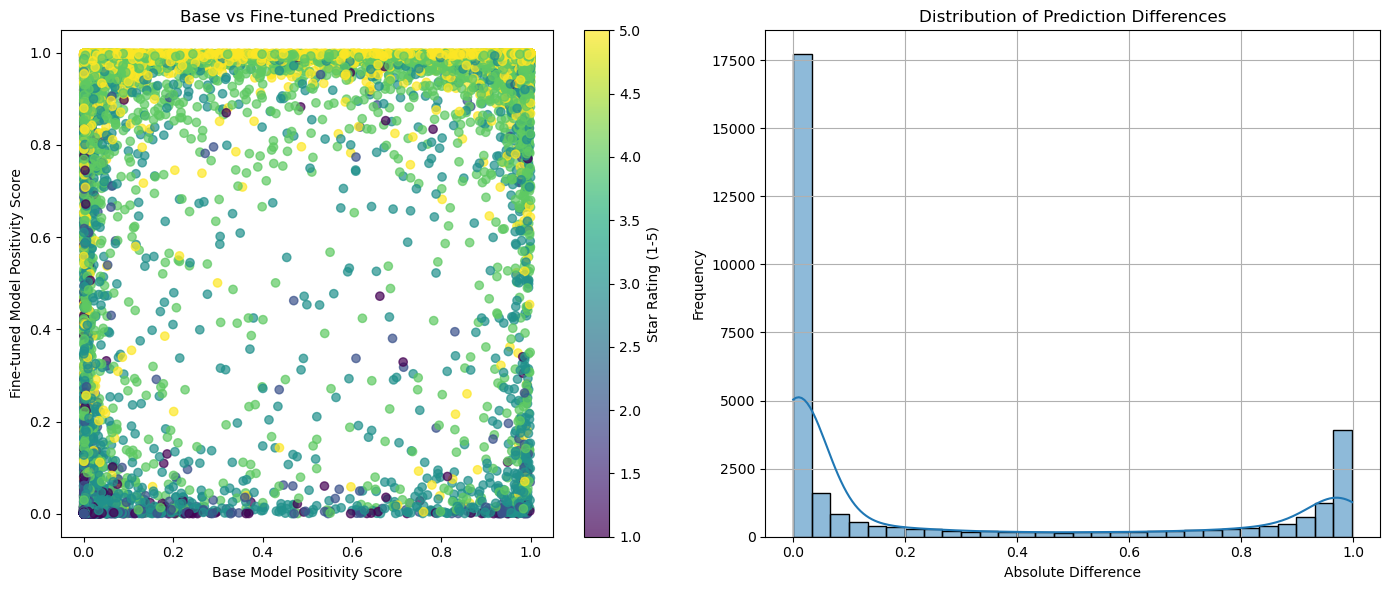

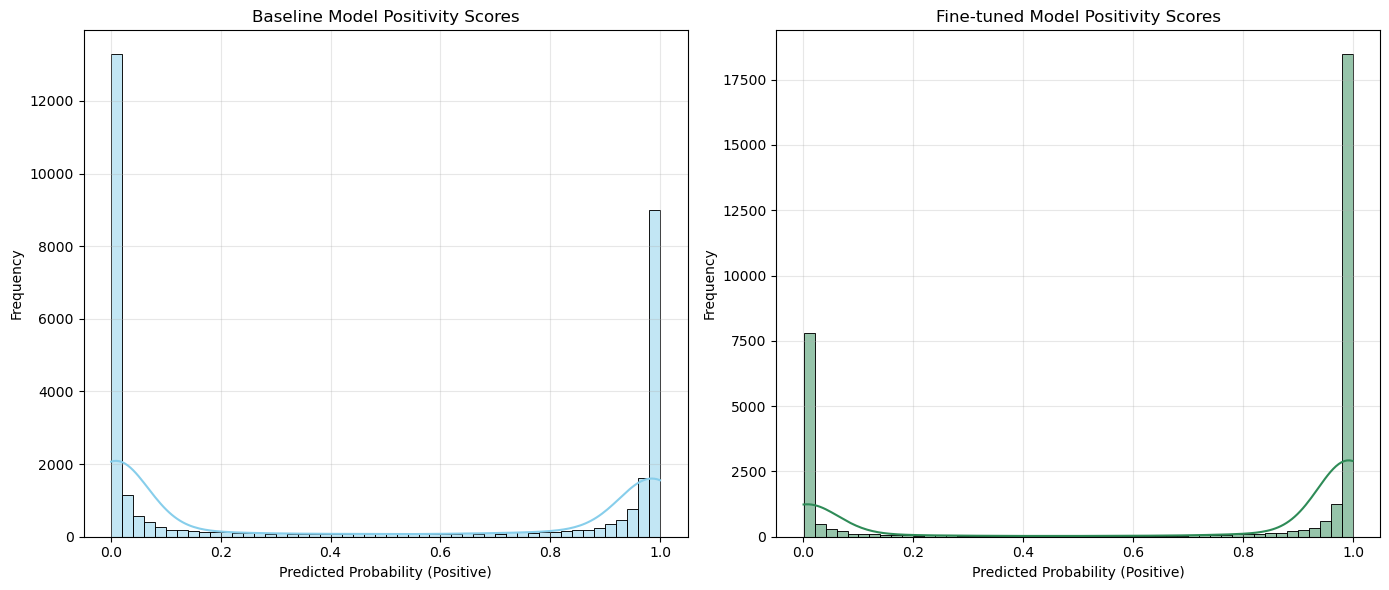

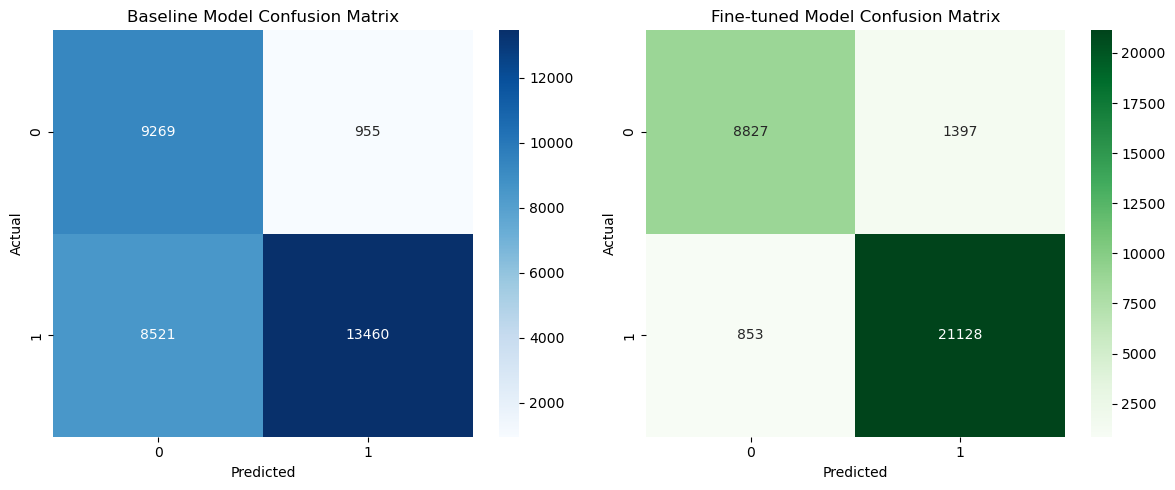

        Model  Accuracy  Precision    Recall        F1
0    Baseline  0.705760    0.93375  0.612347  0.739642
1  Fine-tuned  0.930135    0.93798  0.961194  0.949445


In [ ]:
# Predictions from both baseline and fine-tuned models
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
scatter = axs[0].scatter(test_df['base_prob'], test_df['ft_prob'], c=test_df['stars_review'], alpha=0.7, cmap='viridis')
axs[0].set_xlabel('Base Model Positivity Score')
axs[0].set_ylabel('Fine-tuned Model Positivity Score')
axs[0].set_title('Base vs Fine-tuned Predictions')
cbar = fig.colorbar(scatter, ax=axs[0])
cbar.set_label('Star Rating (1-5)')
sns.histplot(test_df['diff'], bins=30, kde=True, ax=axs[1])
axs[1].set_title('Distribution of Prediction Differences')
axs[1].set_xlabel('Absolute Difference')
axs[1].set_ylabel('Frequency')
axs[1].grid(True)
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(test_df['base_prob'], bins=50, kde=True, ax=axs[0], color='skyblue')
axs[0].set_title('Baseline Model Positivity Scores')
axs[0].set_xlabel('Predicted Probability (Positive)')
axs[0].set_ylabel('Frequency')
axs[0].grid(alpha=0.3)
sns.histplot(test_df['ft_prob'], bins=50, kde=True, ax=axs[1], color='seagreen')
axs[1].set_title('Fine-tuned Model Positivity Scores')
axs[1].set_xlabel('Predicted Probability (Positive)')
axs[1].set_ylabel('Frequency')
axs[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Confusion Matrices
cm_base = confusion_matrix(test_df['positive_review'], test_df['base_label'])
cm_ft = confusion_matrix(test_df['positive_review'], test_df['pred_label'])
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Baseline Model Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Fine-tuned Model Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
plt.tight_layout()
plt.show()


# Metrics
metrics = {
    'Model': ['Baseline', 'Fine-tuned'],
    'Accuracy': [base_results['accuracy'], ft_results['accuracy']],
    'Precision': [base_results['precision'], ft_results['precision']],
    'Recall': [base_results['recall'], ft_results['recall']],
    'F1': [base_results['f1'], ft_results['f1']]
}
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

### 4. Review-Level Results
Print side-by-side predictions and selected token previews to explore how contextual fine-tuning shifted model interpretations: 
- **High-Impact Differences**: Top reviews with the largest predicted sentiment difference between baseline and fine-tuned models
- **Disagreement Sampling**: Identify and sample reviews where models disagreed in classification (e.g., baseline = negative, fine-tuned = positive)

In [ ]:
# High-impact differences
top_diff = test_df.sort_values('diff', ascending=False).head(20)
for i, row in top_diff.iterrows():
    print(f'\n{'='*80}')
    print(f'Review ID: {row['review_id']}')
    print(f'Star Rating: {row['stars_review']} ★')
    print(f'Baseline Positivity: {row['base_prob']:.4f} | Fine-tuned Positivity: {row['ft_prob']:.4f}')
    print(f'Tokens: {row['augmented_text'].split()[:10]}...')
    print(f'\nReview Text:\n{row['text']}')


Review ID: XYhDyHQRKBq6WCTkLUMyYA
Star Rating: 5.0 ★
Baseline Positivity: 0.0003 | Fine-tuned Positivity: 0.9984
Tokens: ['[POST_2020]', '[NOT_USEFUL]', '[NOT_FUNNY]', '[NOT_COOL]', '[NEW_BUSINESS]', '[HIGH_STABILITY]', '[FL]', 'I', 'was', 'absolutely']...

Review Text:
I was absolutely blown away by the amazing, attentive service and the delish food. The staff was so friendly. Will be returning again very soon

Review ID: dqxOoIjeAm4LKCJn_ooRLw
Star Rating: 5.0 ★
Baseline Positivity: 0.0006 | Fine-tuned Positivity: 0.9986
Tokens: ['[PRE_2020]', '[NOT_USEFUL]', '[NOT_FUNNY]', '[NOT_COOL]', '[ESTABLISHED]', '[LOW_STABILITY]', '[FL]', 'Been', 'coming', 'here']...

Review Text:
Been coming here since the early 90's for the best French onion soup in the world. Great burgers and prime rib too.

Review ID: y_VP-H1F42Ftj2j9uKTXNw
Star Rating: 5.0 ★
Baseline Positivity: 0.0003 | Fine-tuned Positivity: 0.9983
Tokens: ['[POST_2020]', '[NOT_USEFUL]', '[NOT_FUNNY]', '[NOT_COOL]', '[ESTABLISHED]',

In [ ]:
# Disagreement cases
disagreements = test_df[test_df['pred_label'] != test_df['base_label']]
case1 = disagreements[(disagreements['base_label'] == 0) & (disagreements['pred_label'] == 1)]
case2 = disagreements[(disagreements['base_label'] == 1) & (disagreements['pred_label'] == 0)]

sampled_case1 = case1.sample(n=min(10, len(case1)), random_state=42)
sampled_case2 = case2.sample(n=min(10, len(case2)), random_state=42)
disagreement_sample = pd.concat([sampled_case1, sampled_case2])

for i, row in disagreement_sample.iterrows():
    print(f'\n{"="*80}')
    print(f'Review ID: {row["review_id"]}')
    print(f'Star Rating: {row["stars_review"]} ★')
    print(f'Baseline Prediction: {"Positive" if row["base_label"] else "Negative"} ({row["base_prob"]:.4f})')
    print(f'Fine-tuned Prediction: {"Positive" if row["pred_label"] else "Negative"} ({row["ft_prob"]:.4f})')
    print(f'Difference: {row["diff"]:.4f}')
    print(f'\nTokens Preview: {" ".join(row["augmented_text"].split()[:10])}...')
    print(f'\nFull Review Text:\n{row["text"]}')


Review ID: Mx69S7Y0c8Lt8nGwu6DE9Q
Star Rating: 4.0 ★
Baseline Prediction: Negative (0.0074)
Fine-tuned Prediction: Positive (0.9980)
Difference: 0.9906

Tokens Preview: [PRE_2020] [NOT_USEFUL] [NOT_FUNNY] [NOT_COOL] [NEW_BUSINESS] [HIGH_STABILITY] [MO] My husband and...

Full Review Text:
My husband and I are weekly Soulard Market goers and have had Lona's amazing beef kabobs. This afternoon we decided to try the Big Thai Wrap with chicken. They were FANTASTIC! Generous portions of wild/brown rice, chicken and veggies and you can choose how mild or spicy you want it as well. There's always a crowd in front of this little stand and we definitely know why. If you're cruising the market, this is a must try.

Review ID: AG3rYYZXzbIHct-ddo4jLQ
Star Rating: 5.0 ★
Baseline Prediction: Negative (0.0010)
Fine-tuned Prediction: Positive (0.9969)
Difference: 0.9959

Tokens Preview: [PRE_2020] [NOT_USEFUL] [NOT_FUNNY] [NOT_COOL] [ESTABLISHED] [LOW_STABILITY] [FL] Yummy We had...

Full Review Text

### 5. Common Words/Theme Extraction
Extract and visualize group-specific linguistic patterns by applying TF-IDF analysis to reviews with high/low predicted positivity from fine-tuned model (for the interpretation of model outputs across different segments (e.g., time, business maturity, state, overall sentiment))

- **Sentiment Inference on Stratified Sample**: Load saved fine-tuned DistilBERT model and compute predicted sentiment probabilities (ft_prob) for each review in the stratified sample

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('./yelp_finetuned_distilbert')
model = AutoModelForSequenceClassification.from_pretrained('./yelp_finetuned_distilbert').to(device)
model.eval()

all_probs = []

for i in tqdm(range(0, len(df), batch_size)):
    batch_texts = df['augmented_text'][i:i+batch_size].tolist()
    encodings = tokenizer(batch_texts, truncation=True, padding=True, return_tensors='pt', max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**encodings)
        probs = torch.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy()
        all_probs.extend(probs)

df['ft_prob'] = all_probs

100%|██████████| 10064/10064 [44:18<00:00,  3.79it/s] 


- **TF-IDF Preparation & Group-Based Term Extraction**: 
    - Preprocess review text: Clean text to remove punctuation, digits, and special tokens, and prepare for TF-IDF vectorization
    - Define review groups: Segment reviews into group-specific top quartiles (e.g., pre-/post-COVID, new vs established businesses, individual states) based on predicted positivity
    - Extract group-distinctive terms: Use TF-IDF scores to identify high-scoring terms that are frequent within each group but uncommon in the overall corpus
    - Generate word clouds: Visualize distinctive terms for each group using WordCloud plots

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jessting/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



PRE_2020 Top vs POST_2020 Top Comparison:


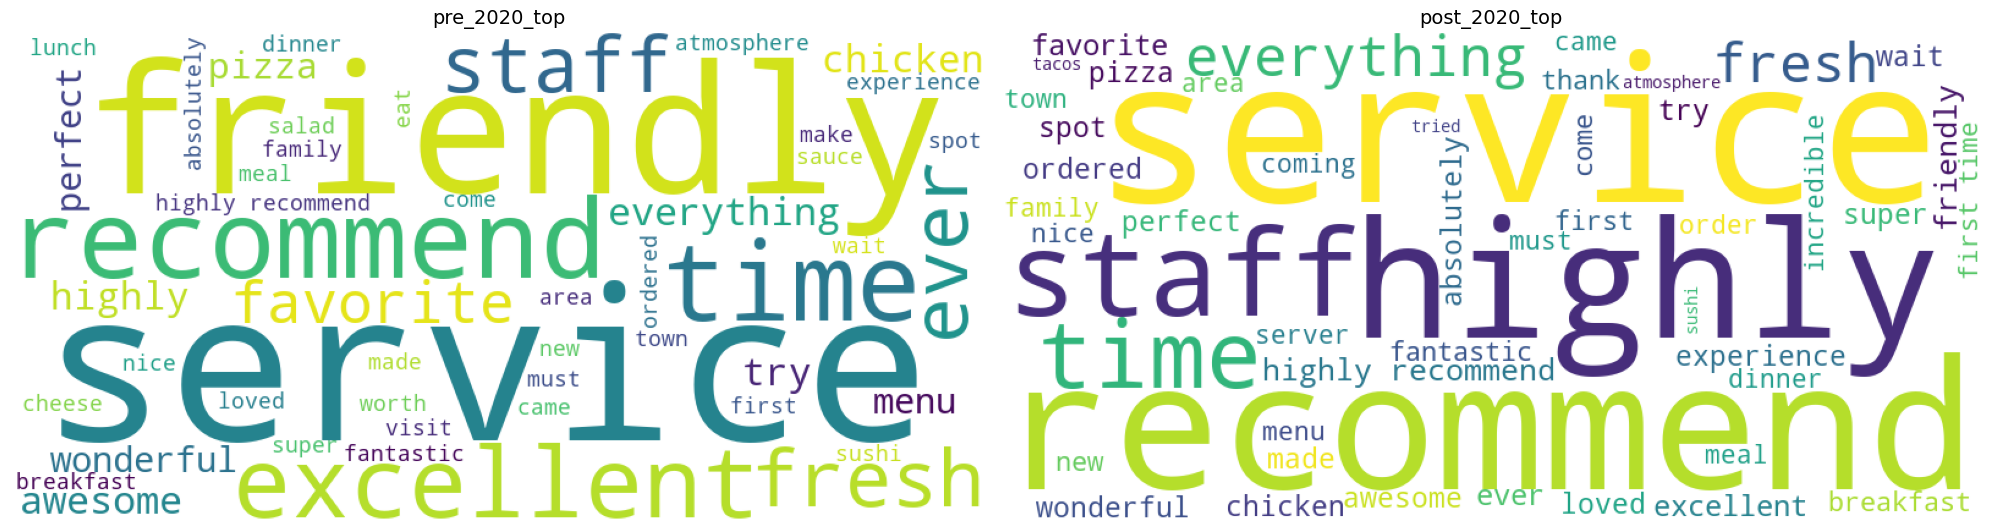


ESTABLISHED Top vs NEW Top Comparison:


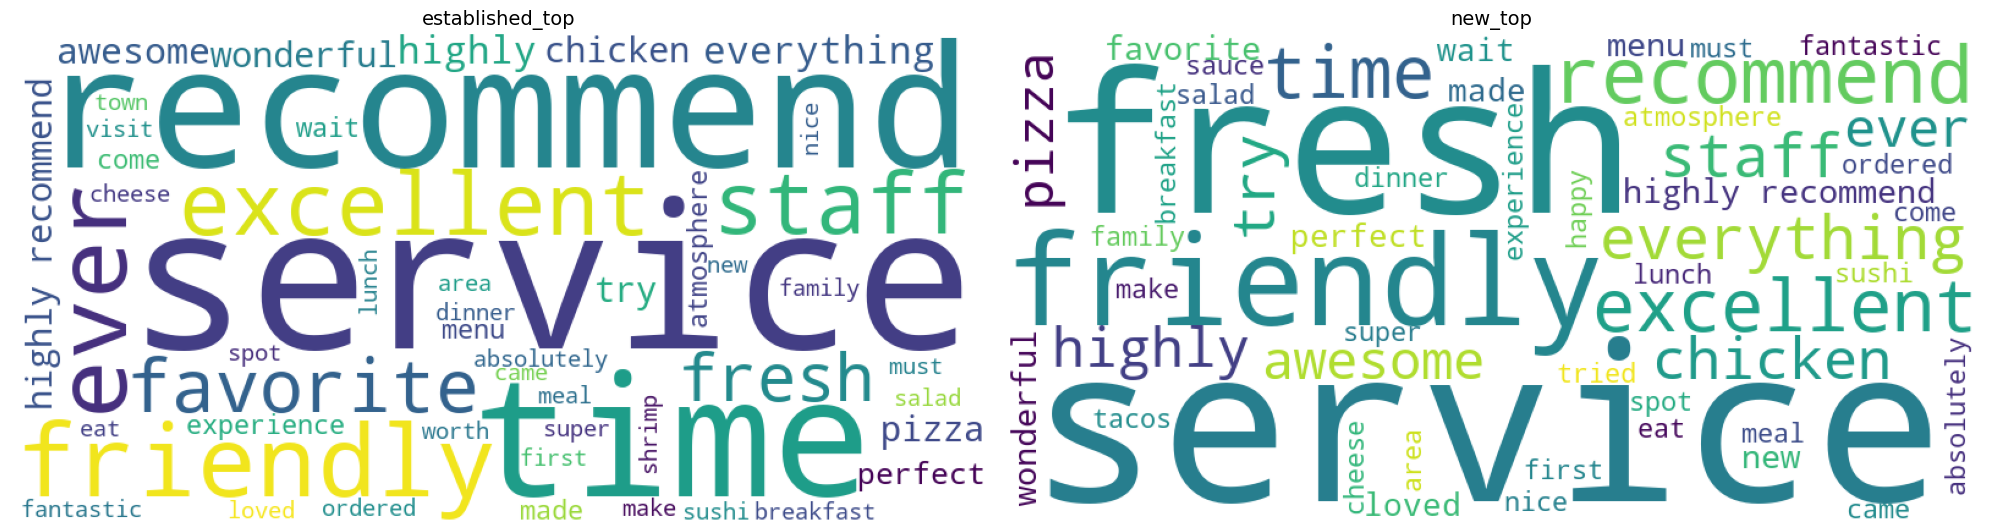


Distinctive terms have been saved to 'distinctive_terms_top_groups.csv'


In [ ]:
nltk.download('stopwords')
nltk_stopwords = stopwords.words('english')
custom_stopwords = ['definitely','love','place','restaurant','best','delicious','amazing','good','great','food','back','like','get','would','got','also','one','really','even','much','many','could','us','go','went','going','always','never','every','well','still','may']
all_stopwords = list(set(nltk_stopwords + custom_stopwords))

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_text'] = df['text'].apply(preprocess_text)
df['clean_text'] = df['clean_text'].fillna('')
corpus = df['clean_text'].tolist()

groups = {}

if 'pre_2020' in df.columns:
    # Pre vs Post 2020
    pre_df = df[df['pre_2020'] == True]
    post_df = df[df['pre_2020'] == False]
    
    pre_threshold = pre_df['ft_prob'].quantile(0.75)
    post_threshold = post_df['ft_prob'].quantile(0.75)
    
    groups['pre_2020_top'] = (df['pre_2020'] == True) & (df['ft_prob'] >= pre_threshold)
    groups['post_2020_top'] = (df['pre_2020'] == False) & (df['ft_prob'] >= post_threshold)

if 'established' in df.columns:
    # Established vs New
    established_df = df[df['established'] == True]
    new_df = df[df['established'] == False]
    
    established_threshold = established_df['ft_prob'].quantile(0.75)
    new_threshold = new_df['ft_prob'].quantile(0.75)
    
    groups['established_top'] = (df['established'] == True) & (df['ft_prob'] >= established_threshold)
    groups['new_top'] = (df['established'] == False) & (df['ft_prob'] >= new_threshold)

# States processing
state_counts = df['state'].value_counts()
valid_states = state_counts[state_counts >= 100].index.tolist()
for state in valid_states:
    state_df = df[df['state'] == state]
    threshold = state_df['ft_prob'].quantile(0.70)
    groups[f'state_{state}_top'] = (df['state'] == state) & (df['ft_prob'] >= threshold)

tfidf = TfidfVectorizer(stop_words=all_stopwords, min_df=2, max_df=0.6, ngram_range=(1,3))
tfidf.fit(corpus)

results = []
wordcloud_data = {}

for name, condition in groups.items():
    try:
        group_docs = df[condition]['clean_text'].tolist()
        if len(group_docs) < 3:
            continue
        tfidf_matrix = tfidf.transform(group_docs)
        avg_tfidf = np.array(tfidf_matrix.mean(axis=0)).flatten()
        feature_names = tfidf.get_feature_names_out()
        top_indices = avg_tfidf.argsort()[::-1][:1000]
        top_terms = [(feature_names[i], avg_tfidf[i]) for i in top_indices]
        doc_counts = (tfidf_matrix > 0).sum(axis=0).A1
        group_size = len(group_docs)
        corpus_size = len(corpus)
        distinctive_terms = []
        for term, score in top_terms:
            term_idx = np.where(feature_names == term)[0][0]
            group_freq = doc_counts[term_idx]/group_size
            corpus_freq = doc_counts[term_idx]/corpus_size
            if (group_freq > 0.1) and (corpus_freq < 0.40):
                distinctive_terms.append((term, score))
        if len(distinctive_terms) < 50:
            distinctive_terms = top_terms[:50]
        for term, score in distinctive_terms[:50]:
            results.append({'category':name, 'term':term, 'score':score})
        wordcloud_data[name] = dict(distinctive_terms[:50])
        plt.figure(figsize=(10,5))
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_data[name])
        plt.imshow(wordcloud)
        plt.title(name)
        plt.axis("off")
        plt.savefig(f'wordcloud_{name}.png')
        plt.close()
    except Exception as e:
        print(f"Error processing {name}: {str(e)}")

def show_comparison(group1, group2):
    if group1 in wordcloud_data and group2 in wordcloud_data:
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_data[group1])
        plt.imshow(wordcloud)
        plt.title(group1, fontsize=14)
        plt.axis("off")
        plt.subplot(1, 2, 2)
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_data[group2])
        plt.imshow(wordcloud)
        plt.title(group2, fontsize=14)
        plt.axis("off")
        plt.tight_layout()
        plt.show()

if 'pre_2020_top' in wordcloud_data and 'post_2020_top' in wordcloud_data:
    print("\nPRE_2020 Top vs POST_2020 Top Comparison:")
    show_comparison('pre_2020_top', 'post_2020_top')

if 'established_top' in wordcloud_data and 'new_top' in wordcloud_data:
    print("\nESTABLISHED Top vs NEW Top Comparison:")
    show_comparison('established_top', 'new_top')

results_df = pd.DataFrame(results)
results_df.to_csv('distinctive_terms_top_groups.csv', index=False)
print("\nDistinctive terms have been saved to 'distinctive_terms_top_groups.csv'")

- **Overall Sentiment Extremes & Theme Comparison**: 
    - Identify extreme sentiment reviews: Define top and bottom 20% of reviews by predicted positivity across the stratified sample
    - Compare top vs bottom themes: Extract and visualize linguistic themes from highly positive and highly negative reviews to interpret sentiment extremes across the dataset

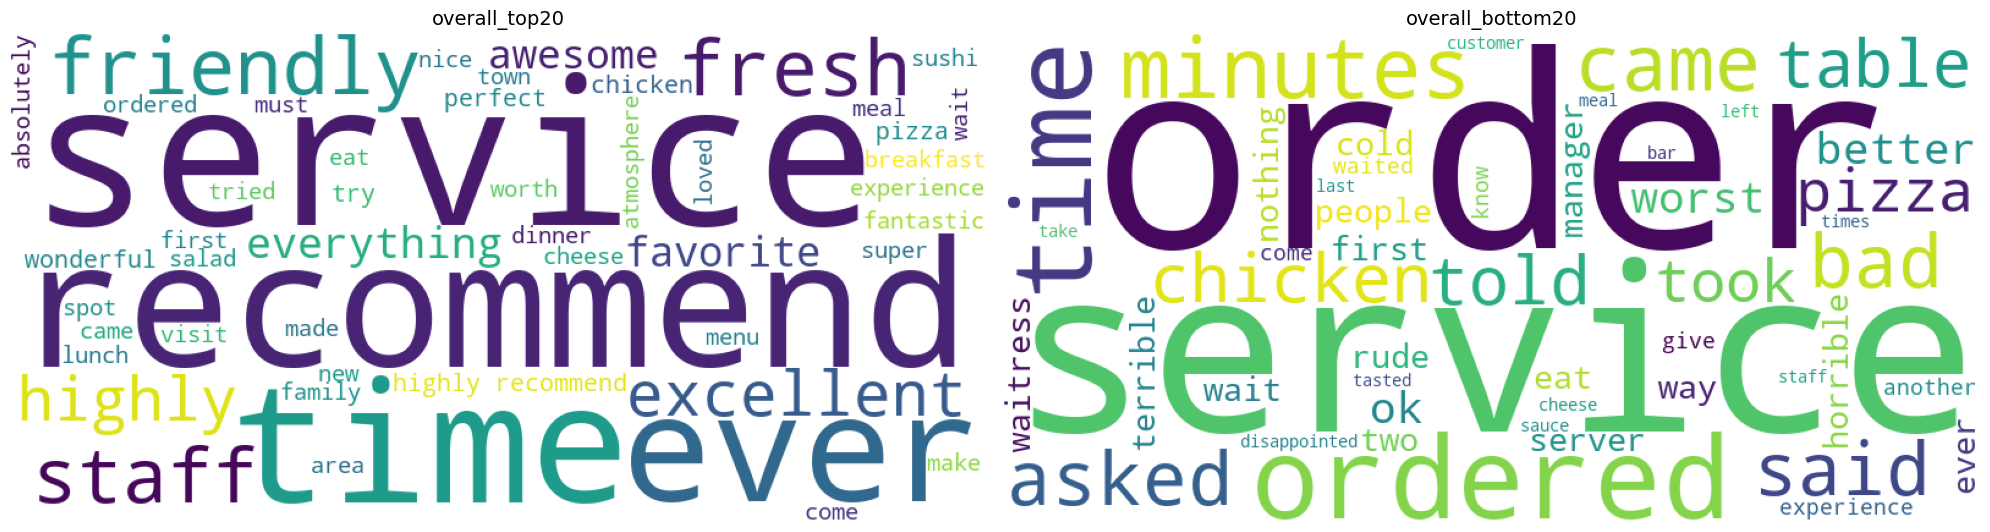

In [ ]:
# Overall top 20% and bottom 20% groups based on fine-tuned positivity scores
top_20_threshold = df['ft_prob'].quantile(0.80)
bottom_20_threshold = df['ft_prob'].quantile(0.20)

groups['overall_top20'] = df['ft_prob'] >= top_20_threshold
groups['overall_bottom20'] = df['ft_prob'] <= bottom_20_threshold

# Generate word clouds for top 20% vs bottom 20%
for name in ['overall_top20', 'overall_bottom20']:
    try:
        group_docs = df[groups[name]]['clean_text'].tolist()
        if len(group_docs) < 3:
            continue
        tfidf_matrix = tfidf.transform(group_docs)
        avg_tfidf = np.array(tfidf_matrix.mean(axis=0)).flatten()
        feature_names = tfidf.get_feature_names_out()
        top_indices = avg_tfidf.argsort()[::-1][:1000]
        top_terms = [(feature_names[i], avg_tfidf[i]) for i in top_indices]
        doc_counts = (tfidf_matrix > 0).sum(axis=0).A1
        group_size = len(group_docs)
        corpus_size = len(corpus)
        distinctive_terms = []
        for term, score in top_terms:
            term_idx = np.where(feature_names == term)[0][0]
            group_freq = doc_counts[term_idx] / group_size
            corpus_freq = doc_counts[term_idx] / corpus_size
            if (group_freq > 0.1) and (corpus_freq < 0.4):
                distinctive_terms.append((term, score))
        if len(distinctive_terms) < 50:
            distinctive_terms = top_terms[:50]
        wordcloud_data[name] = dict(distinctive_terms[:50])
        plt.figure(figsize=(10, 5))
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_data[name])
        plt.imshow(wordcloud)
        plt.title(name.replace('_', ' ').title())
        plt.axis("off")
        plt.savefig(f'wordcloud_{name}.png')
        plt.close()
    except Exception as e:
        print(f"Error processing {name}: {str(e)}")

show_comparison('overall_top20', 'overall_bottom20')

In [ ]:
df.to_csv('yelp_sample_predictions.csv', index=False)
test_df.to_csv('yelp_sample_test_comparison.csv', index=False)